In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt    
from sklearn.model_selection import train_test_split

In [3]:
def create_ts_dataset(
                        data_path='data/Safety Monitoring.csv',
                        sel_window = 24*7,
                        pred_window = 1
                        ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df = df.resample('D', on='Timestamp').mean()

        X, Y = [], []
        for i in range(len(df) - sel_window - pred_window):
                data = df.iloc[i:i+sel_window]
                target = df.iloc[i+sel_window:i+sel_window+pred_window][['Precipitation (mm)','Wind Speed (m/s)','Thunderstorm (0/1)']]
                X.append(data.values)
                Y.append(target.values)

        X = np.array(X).squeeze()
        Y = np.array(Y).squeeze()

        return X, Y

In [4]:
X, Y = create_ts_dataset()
print(f"X shape: {X.shape}\nY shape: {Y.shape}")

X shape: (2388, 168, 4)
Y shape: (2388, 3)


In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.15, 
                                                random_state=42
                                                )

In [6]:
cnn_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(168, 4)),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),
                                        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),
                                        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(3)
                                        ])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 166, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 83, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 40, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 128)          0

In [7]:
cnn_model.compile(
                optimizer='adam', 
                metrics=['mae'],
                loss='mse'
                )

In [8]:
history = cnn_model.fit(
                        Xtrain, Ytrain, 
                        epochs=100, batch_size=256, 
                        validation_data=(Xtest, Ytest),
                        callbacks=[
                                    tf.keras.callbacks.EarlyStopping(
                                                                 patience=100, 
                                                                 restore_best_weights=True
                                                                 )
                                    ]
                        )

Epoch 1/100
8/8 [==============================] - 3s 41ms/step - loss: 36.9757 - mae: 4.1995 - val_loss: 8.7663 - val_mae: 1.8150
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 13.0740 - mae: 2.4695 - val_loss: 13.7783 - val_mae: 2.0690
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 11.0540 - mae: 2.2653 - val_loss: 8.3649 - val_mae: 1.6552
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 10.2649 - mae: 2.2339 - val_loss: 8.9472 - val_mae: 1.6302
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 9.3936 - mae: 2.0474 - val_loss: 8.8015 - val_mae: 1.5805
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 9.0823 - mae: 2.0085 - val_loss: 8.5945 - val_mae: 1.5743
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 8.8359 - mae: 1.9161 - val_loss: 8.5561 - val_mae: 1.5905
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 8.5255 - mae: 1.8925

In [9]:
cnn_model.save('artifacts/safety_monitoring.h5')

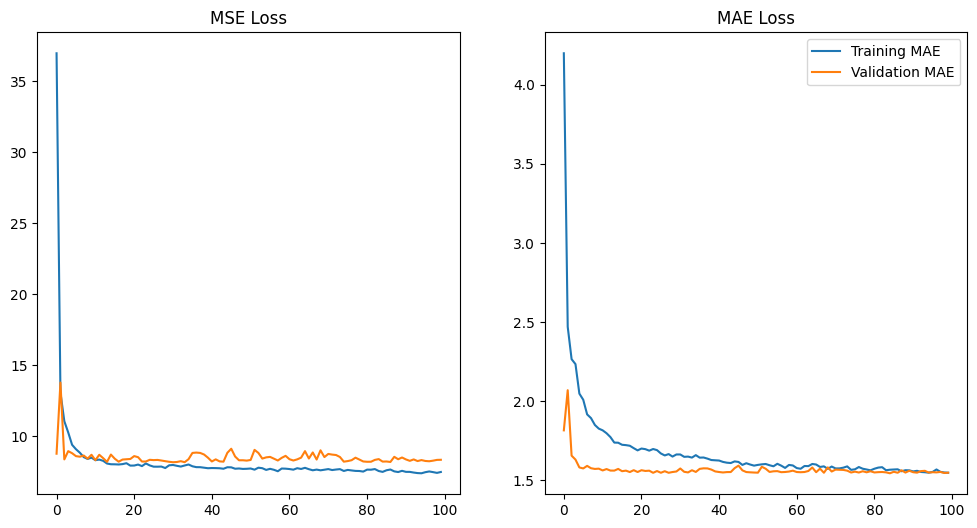

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Loss')

plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
model_safety = tf.keras.models.load_model('artifacts/safety_monitoring.h5')
model_safety.compile(
                    optimizer='adam', 
                    metrics=['mae'],
                    loss='mse'
                    )

In [13]:
def calculate_hazard_risk(rain, wind_speed, thunderstorm):
    risk = None
    if rain > 80:
        risk = "Heavy rainfall causes water to seep into electrical installations, leading to short circuits and electrocution risks."
    elif 50 <= rain <= 80:
        risk = "Moderate rainfall can cause water ingress, leading to electrical faults in exposed systems."
    else:
        risk = "Light rain does not pose a significant risk to electrical safety."

    if wind_speed > 16:
        risk = "High winds increase the likelihood of power line damage, surges, and outages."
    elif 10 <= wind_speed <= 16:
        risk = "Moderate winds may cause structural damage to electrical infrastructure, leading to power outages."
    else:
        risk = "Mild winds do not impact power infrastructure."

    if thunderstorm == 1:
        risk = "Lightning increases the risk of electrical surges and fires."
    else:
        risk = "No thunderstorms, no lightning risk."
    
    if risk is None:
        risk = "Undefined risk level"
    return risk


def inference_safety(
                    data_path='data/Safety Monitoring.csv',
                    sel_window = 24*7
                    ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df = df.resample('D', on='Timestamp').mean()

        data = df.iloc[-sel_window:]
        data = np.expand_dims(data.values, axis=0)
        prediction = model_safety.predict(data).squeeze()
        prediction[-1] = 1 if prediction[-1] > 0.5 else 0
        hazard = calculate_hazard_risk(*prediction)
        return hazard

In [14]:
inference_safety()

1/1 [==============================] - 0s 17ms/step


'No thunderstorms, no lightning risk.'